# The process P265

In [2]:
# initialise:

%run /Users/etc/Projects/201612-lanl-analysis/LANL-analysis/0-lanl-init.ipynb

Build an RDD which restricts to the P265 events:

In [3]:
proc_p265 = procs.filter(lambda x: x[4] == 'P265').map(lambda x: x[0:4] + [x[5]])
proc_p265.cache()

PythonRDD[6] at RDD at PythonRDD.scala:43

How many process P265 events do we see, and how many computers are involved?

In [6]:
from __future__ import print_function

nr_cmps = proc_p265.map(lambda x: x[3]).distinct().count()

print("Nr P265 events:", proc_p265.count())
print("Nr computers:", nr_cmps)

Nr P265 events: 20004346
Nr computers: 11650


So in other words, 20M out of 426M, or 4.7% of all process events are P265. Virtually all computers are involved. 

In [7]:
from collections import Counter

binsize = 3600

def mapper(x):
    return (x[0]/binsize, x[1:5])

"""
 mapper will output collections of records like:
 (timebin, ['C1001$', 'DOM1', 'C1001', 'Start'])
"""

def reducer(dat):
    n = len(dat)
    user = dict(Counter([x[0] for x in dat]))
    domn = dict(Counter([x[1] for x in dat]))
    comp = dict(Counter([x[2] for x in dat]))
    nr_user = len(user.keys())
    nr_comp = len(comp.keys())
    nr_domn = len(domn.keys())
    cmax_prop = max(comp.values())/float(n)
    cmax = [k for (k,v) in comp.items() if v == max(comp.values())][0]
    return [n, nr_user, nr_comp, nr_domn, cmax_prop, cmax]

# map-reduce job:
proc_p265_ts = proc_p265.map(mapper)\
                    .groupByKey()\
                    .map(lambda x : (x[0], reducer(list(x[1]))))\
                    .collect()
            
proc_p265_ts_dict = dict(proc_p265_ts)

Now let's view these time series:

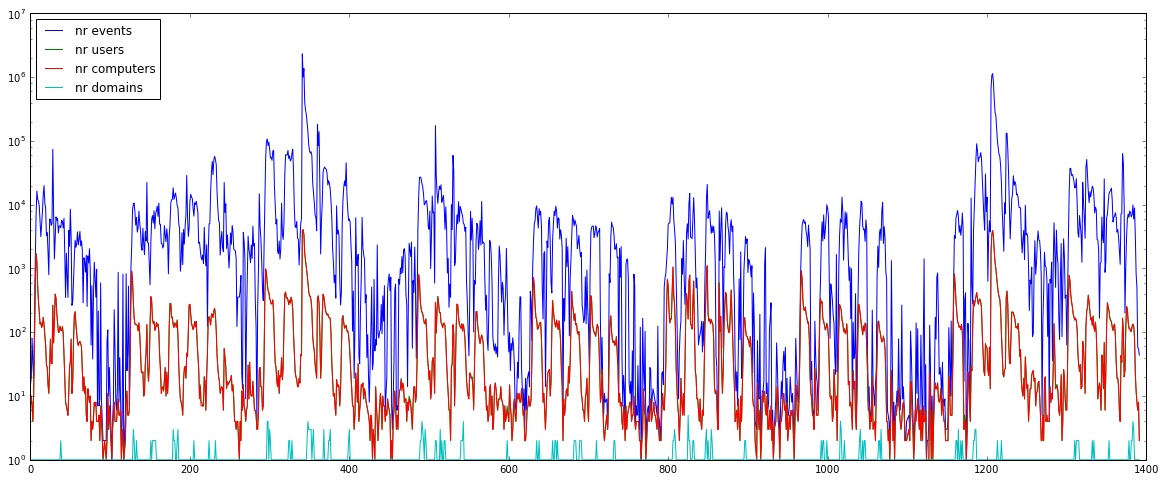

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

time = sorted(proc_p265_ts_dict.keys())
nr_events = [proc_p265_ts_dict[t][0] for t in time]
nr_user = [proc_p265_ts_dict[t][1] for t in time]
nr_comp = [proc_p265_ts_dict[t][2] for t in time]
nr_domn = [proc_p265_ts_dict[t][3] for t in time]

plt.figure(figsize=(20,8))
ts1, = plt.semilogy(time, nr_events, label='nr events')
ts2, = plt.semilogy(time, nr_user, label='nr users')
ts3, = plt.semilogy(time, nr_comp, label='nr computers')
ts4, = plt.semilogy(time, nr_domn, label='nr domains')
plt.legend(handles=[ts1, ts2, ts3, ts4], loc='upper left')
plt.show()

So P265 is a ubiquitous kernel process. Note that nr of users equals nr of computers - presumably always root.

What's the typical duration of the process? The factor of 10 between computers and events suggests each computer is seeng ~10 P265 events per time-bin (= hour here).

Is the process P265 associated with network events? See next section.

In [9]:
proc_p265.unpersist()

PythonRDD[6] at RDD at PythonRDD.scala:43

<h2>Conclusions</h2>

Of the process P265 most implicated in the change event, we've learnt:

<ol>
<li> it is ubiquitous throughout the collection period, touching all computers and accounting for 4.7% of all process events in the data;
<li> its distribution is fairly stationary, with rate of occurence exhibiting a daily cycle;
<li> it appears to be a kernel process since user is always root.
</ol>

<h2>ADAP</h2>

This part of the analysis raises questions around conditioning the data on particular values of fields. In this case we were led to fix the value of the process field at 'P265'. (More generally the conditioning might be to some probability distribution over values.) 

Questions:

<ul>
<li> How does such conditioning affect global time series that have already been benchmarked across the data?
<li> How does it affect the distributions in other data columns? (E.g. fixing P265 results in 'user' and 'computer' being correlated (at root).)
<li> In particular, how does it affect the supports of the other data columns (i.e. the numbers of distinct values seen in them)?
</ul>

In general, what are the decision criteria for such conditioning? (We were led to the value 'P265' in one particular data column from the analysis of the previous notebook. What else might trigger this choice?) 

And how does one prune the search (over values of fields to condition on) in order to keep computation tractable?